In [8]:
import os
import json
import glob
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objs as go

from PIL import Image, ImageOps
from skimage import io
from skimage.color import rgba2rgb, rgb2xyz
from tqdm import tqdm
from dataclasses import dataclass
from math import floor, ceil
import random

# Train data generation
import collections
import csv
from pathlib import Path
from typing import List, Tuple, Any

import time
import re
from sklearn import preprocessing
import lightgbm as lgb

pd.set_option("display.max_columns", 100)

In [9]:
# Preprocess

# Check out each file. Content, images

root_path = "../input/indoor-location-navigation/"
train_paths = glob.glob(root_path + "train" + "/*/*/*")
test_paths = glob.glob(root_path + "test" + "/*")
metafiles = glob.glob(root_path + "metadata" + "/*")

print("No. Files in Train: {:,}".format(len(train_paths)), "\n" +
      "No. Files in Test: {:,}".format(len(test_paths)), "\n" +
      "No. of metadata files: {:,}".format(len(metafiles)))

# Reading in 1 file
def pick_example(max_range, paths):
    ex = random.randint(0, max_range)
    example_path = paths[ex]
    path = f"{example_path}"
    paths = path.split("/")
    site = paths[4]
    floorNo = paths[5]
    floor_plan_filename = f"{root_path}metadata/{site}/{floorNo}/floor_image.png"
    json_plan_filename = f"{root_path}metadata/{site}/{floorNo}/floor_info.json"
    with open(json_plan_filename) as json_file:
        json_data = json.load(json_file)
    width_meter = json_data["map_info"]["width"]
    height_meter = json_data["map_info"]["height"]
    return path, site, floorNo, floor_plan_filename, json_plan_filename, width_meter, height_meter

path, site, floorNo, floor_plan_filename, \
json_plan_filename, width_meter, height_meter = pick_example(len(train_paths), train_paths)
print("example path: ", path)
print("site: ", site)
print("floorNo: ", floorNo)
print("floor_plan_filename: ", floor_plan_filename)
print("json_plan_filename: ", json_plan_filename)
print("width: {}, height: {} ".format(width_meter, height_meter))

with open(path) as p:
    lines = p.readlines()
print("No. Lines in 1 example: {:,}". format(len(lines)))

No. Files in Train: 26,925 
No. Files in Test: 626 
No. of metadata files: 204
example path:  ../input/indoor-location-navigation/train/5cd56b90e2acfd2d33b5e33f/F3/5d087d1bbb84450008f56ba2.txt
site:  5cd56b90e2acfd2d33b5e33f
floorNo:  F3
floor_plan_filename:  ../input/indoor-location-navigation/metadata/5cd56b90e2acfd2d33b5e33f/F3/floor_image.png
json_plan_filename:  ../input/indoor-location-navigation/metadata/5cd56b90e2acfd2d33b5e33f/F3/floor_info.json
width: 173.37152638383503, height: 130.57778814608847 
No. Lines in 1 example: 16,853


In [10]:
# Get submission file
sub_df = pd.read_csv("/kaggle/input/indoor-location-navigation/sample_submission.csv")
sub_df = sub_df["site_path_timestamp"].apply(lambda x: pd.Series(x.split("_")))
sub_df.columns = ["site", "file", "timestamp"]
display(sub_df.head())

,site,file,timestamp
0,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000000009
1,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000009017
2,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000015326
3,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000018763
4,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000022328


In [11]:
# train number setting
train_num = len(train_paths) - 1
# train_num = round(len(train_paths) / 2)
# train_num = 300

# 200 train paths come out with ~1000 examples, so multiply train examples by 5 to extract similar no. of examples
# test_num = train_num * 5
# test_num = len(sub_df) - 1
print(train_num)

300 10132


In [12]:
# for line in lines[:200]:
#     print(line)

In [13]:
# using github repo in kaggle kernels
# https://www.kaggle.com/getting-started/71642
!cp -r ../input/indoorlocationcompetition20master/indoor-location-competition-20-master/* ./

In [14]:
# Import custom function from the repository
from io_f import read_data_file

# Read in 1 random example
path, site, floorNo, floor_plan_filename, \
json_plan_filename, width_meter, height_meter = pick_example(len(train_paths), train_paths)
sample_file = read_data_file(path)

# You can access the information for each variable:
# Each data is split for time
# Metadata is expressed with "#"

# for i in sample_file.acce[:, [0]]:
#     print(i)
#     print(int(i))

# print("~~~ Example ~~~")
# print("acce: {}".format(sample_file.acce), "\n" +
#       "acce shape: {}".format(sample_file.acce.shape), "\n" +
#       "acacce_uncalice: {}".format(sample_file.acce_uncali), "\n" +
#       "acacce_uncalice shape: {}".format(sample_file.acce_uncali.shape), "\n" +
#       "ahrs: {}".format(sample_file.ahrs), "\n" +
#       "ahrs shape: {}".format(sample_file.ahrs.shape), "\n" +
#       "gyro: {}".format(sample_file.gyro), "\n" +
#       "gyro shape: {}".format(sample_file.gyro.shape), "\n" +
#       "gyro_uncali: {}".format(sample_file.gyro_uncali), "\n" +
#       "gyro_uncali shape: {}".format(sample_file.gyro_uncali.shape), "\n" +
#       "ibeacon: {}".format(sample_file.ibeacon), "\n" +
#       "ibeacon shape: {}".format(sample_file.ibeacon.shape), "\n" +
#       "magn: {}".format(sample_file.magn), "\n" +
#       "magn shape: {}".format(sample_file.magn.shape), "\n" +
#       "magn_uncali: {}".format(sample_file.magn_uncali), "\n" +
#       "magn_uncali shape: {}".format(sample_file.magn_uncali.shape), "\n" +
#       "waypoint: {}".format(sample_file.waypoint), "\n" +
#       "waypoint shape: {}".format(sample_file.waypoint.shape), "\n" +
#       "wifi: {}".format(sample_file.wifi), "\n" +
#       "wifi shape: {}".format(sample_file.wifi.shape))

In [15]:
def show_site_png(root_path, site):
    floor_paths = glob.glob(root_path + "metadata/" + site + "/*/floor_image.png")
    n = len(floor_paths)
    print("No. of floor paths: ", n)

    # Create the custom number of rows & columns
    ncols = [ceil(n / 3) if n > 4 else 4][0]
    nrows = [ceil(n / ncols) if n > 4 else 1][0]

    plt.figure(figsize=(16, 10))
    plt.suptitle(f"Site no. '{site}'", fontsize=18)

    # Plot image for each floor
    for k, floor in enumerate(floor_paths):
        # plt.subplot(nrows, ncols, k+1)
        plt.subplot(ncols, nrows, k+1)
        plt.rcParams["figure.facecolor"] = "white"

        image = Image.open(floor)

        plt.imshow(image)
        plt.axis("off")
        title = floor.split("/")[5]
        plt.title(title, fontsize=15)

No. of floor paths:  4


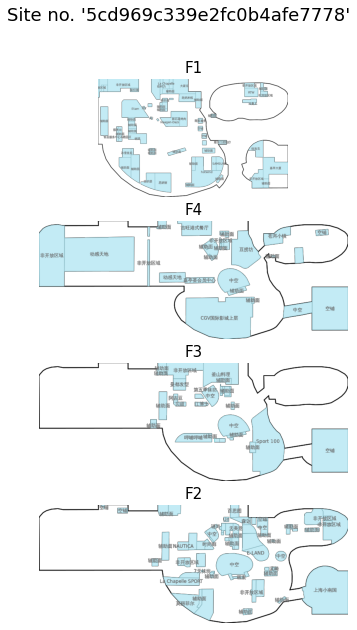

In [16]:
path, site, floorNo, floor_plan_filename, json_plan_filename, width_meter, height_meter = pick_example(len(train_paths), train_paths)
show_site_png(root_path, site=site)

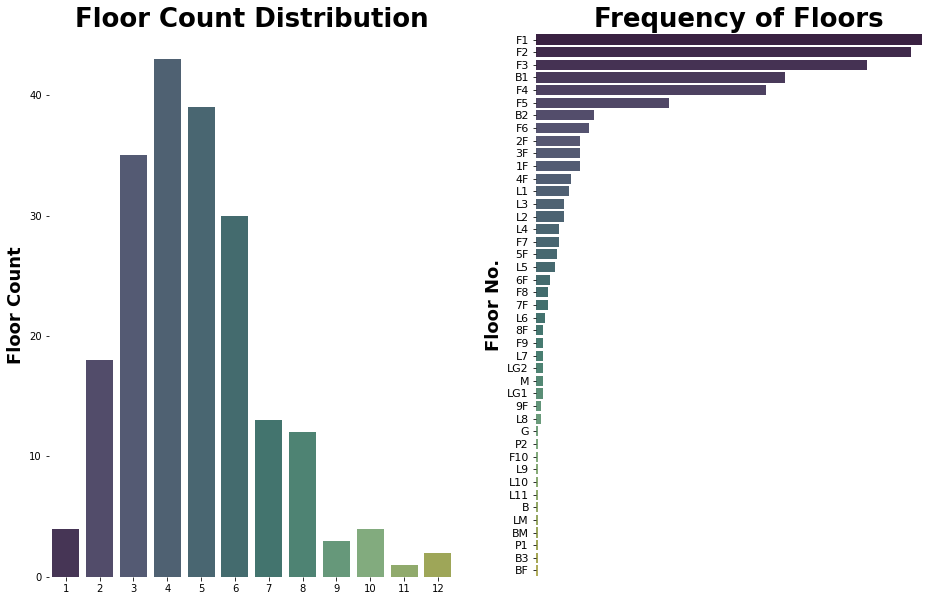

In [17]:
# Checking the floor number distribution

all_floors = glob.glob("../input/indoor-location-navigation/metadata/*/*")
all_sites = glob.glob("../input/indoor-location-navigation/metadata/*")
floor_no = []
floor_counts = []

# Floor count
for site in all_sites:
    floor_count = len([name for name in os.listdir(site)])
    floor_counts.append(floor_count)

floor_counts_df = pd.DataFrame(floor_counts, columns=["F_Count"])
floor_counts_df = floor_counts_df["F_Count"].value_counts().reset_index()
floor_counts_df = floor_counts_df.sort_values("index", ascending=True)

# Extract only the floor number
for floor in all_floors:
    no = floor.split("/")[5]
    floor_no.append(no)
    
floor_no = pd.DataFrame(floor_no, columns=["No"])
floor_no = floor_no["No"].value_counts().reset_index()
floor_no = floor_no.sort_values("No", ascending=False)

# ToDo: Floor expressions need to be fixed
# 1F -> F1, L1 -> F1, G -> F1 etc

# Plot
# display(floor_counts_df.head(10))

fig, axes = plt.subplots(ncols=2, figsize=(16, 10))
axes[0] = sns.barplot(data=floor_counts_df, x="index", y="F_Count", palette="viridis", saturation=0.4, ax=axes[0])
axes[0].set_title("Floor Count Distribution", size = 26, weight="bold")
axes[0].set_xlabel("")
axes[0].set_ylabel("Floor Count", size = 18, weight="bold")

axes[1] = sns.barplot(data=floor_no, x="No", y="index", palette="viridis", saturation=0.4, ax=axes[1])
axes[1].set_title("Frequency of Floors", size = 26, weight="bold")
axes[1].set_xlabel("")
axes[1].set_ylabel("Floor No.", size = 18, weight="bold")

plt.xticks([])
plt.yticks(fontsize=11)
sns.despine(left=True, bottom=True);

No. of geojson file: 981
File path: ../input/indoor-location-navigation/metadata/5cd969b839e2fc0b4afe6edc/F2/geojson_map.json
SiteID: 5cd969b839e2fc0b4afe6edc
Floor: F2
Floor info: {'Vr': '000200', 'category': 'floor', 'name': 'F2', 'code': 'GD0012880110200001', 'floor_num': 2, 'type': 'floor'}


'floor_num_df length: 981'

,site_id,floor_no,floor_no_json
0,5cd56c0ce2acfd2d33b6ab27,B1,-1.0
1,5cd56c0ce2acfd2d33b6ab27,F3,3.0
2,5cd56c0ce2acfd2d33b6ab27,F2,2.0
3,5cdbc652853bc856e89a8694,B1,-1.0
4,5cdbc652853bc856e89a8694,F1,1.0


<Figure size 432x288 with 0 Axes>

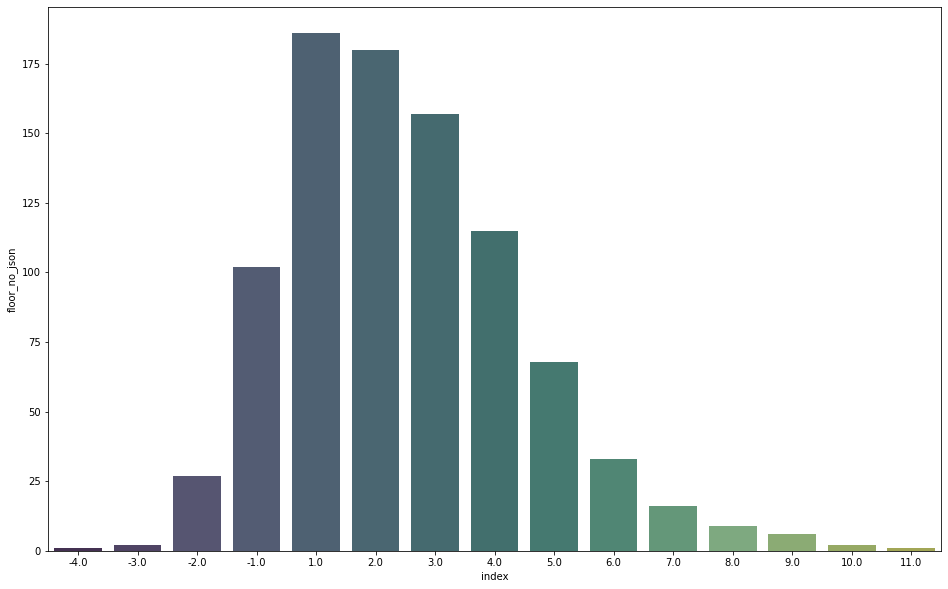

In [18]:
# Metadata checking (GeoJSON)
# This is a vector representation of floor map
geojson_paths = glob.glob("../input/indoor-location-navigation/metadata/*/*/geojson_map.json")
print("No. of geojson file: {}".format(len(geojson_paths)))

# Print one example
ex = random.randint(0, len(geojson_paths))
geojson_file_name = geojson_paths[ex]
with open(geojson_file_name) as json_file:
    paths = geojson_file_name.split("/")
    site_id = paths[4]
    floor = paths[5]
    json_data = json.load(json_file)
    json_properties = json_data["features"][0]["properties"]
    print("File path: {}".format(geojson_file_name))
    print("SiteID: {}".format(site_id))
    print("Floor: {}".format(floor))
    print("Floor info: {}".format(json_properties))

# create id and floor number matching file
site_ids = []
floor_no = []
floor_no_json = []

for i in range(0, len(geojson_paths)):
    with open(geojson_paths[i]) as f:
        paths = geojson_paths[i].split("/")
        site_id = paths[4]
        floor = paths[5]
        site_ids.append(site_id)
        floor_no.append(floor)
        d = json.load(f)
        try:
            floor_no_json.append(d["features"][0]["properties"]["floor_num"])
        except:
            floor_no_json.append(np.nan)

floor_num_df = pd.DataFrame(
    {"site_id": site_ids,
     "floor_no": floor_no,
     "floor_no_json": floor_no_json,
    })

display("floor_num_df length: {}".format(len(floor_num_df)))
display(floor_num_df.head())

# Get floormap dict to be used later
floor_map_pairs = list(zip(floor_num_df["floor_no"], floor_num_df["floor_no_json"]))
floor_map_pairs = np.unique(floor_map_pairs, axis=0) # get unique pair
# print(floor_map_pairs) # to be used as floor_map later

# Plot distribution
floor_num_count_df = floor_num_df["floor_no_json"].value_counts().reset_index()
floor_num_count_df = floor_num_count_df.sort_values("floor_no_json", ascending=False)
# display(floor_num_count_df)
# print(len(floor_num_count_df["floor_no_json"] == np.nan))

fig = plt.figure()
ax = plt.subplots(figsize=(16, 10))
sns.barplot(data=floor_num_count_df, x="index", y="floor_no_json", palette="viridis", saturation=0.4)
fig.show()

# Just in case: Need for altitude info in geoJSON
# from pyproj import Proj, transform
# print(transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), -0.1285907, 51.50809))  # longitude first, latitude second.
# output (meters east of 0, meters north of 0): (-14314.651244750548, 6711665.883938471)

Processing ../input/indoor-location-navigation/train/5d2709dd03f801723c32cfb6/L2/5d58f9cdec821f0008c2570a.txt...
Waypoints: [[1.56611165e+12 3.23382080e+02 1.33123280e+02]
 [1.56611166e+12 3.33832900e+02 1.29963410e+02]
 [1.56611168e+12 3.31983730e+02 1.35620480e+02]]



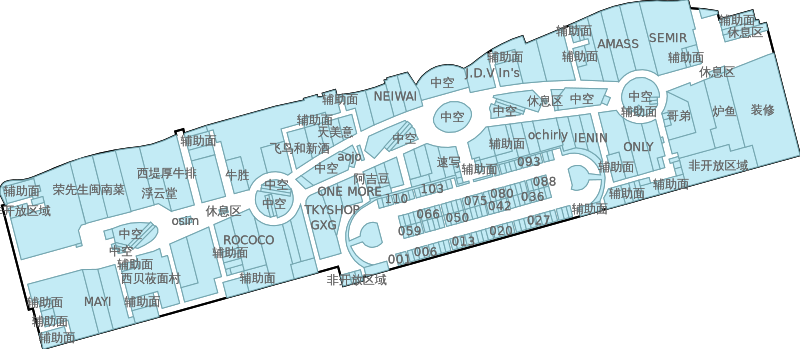

In [20]:
# More viz on accelerometers, wifi etc in one go
from visualize_f import visualize_trajectory, visualize_heatmap
from main import extract_wifi_rssi, extract_wifi_count
from main import calibrate_magnetic_wifi_ibeacon_to_position
from main import extract_magnetic_strength
from main import extract_ibeacon_rssi

# Visualizing magnetic strength
path, site, floorNo, floor_plan_filename, \
json_plan_filename, width_meter, height_meter = pick_example(len(train_paths), train_paths)

# extract mag, wifi, beacon of one example
mwi_datas = calibrate_magnetic_wifi_ibeacon_to_position([path])
magnetic_strength = extract_magnetic_strength(mwi_datas)
wifi_rssi = extract_wifi_rssi(mwi_datas)
wifi_counts = extract_wifi_count(mwi_datas)
ibeacon_rssi = extract_ibeacon_rssi(mwi_datas)
ibeacon_ummids = list(ibeacon_rssi.keys())
target_ibeacon = ibeacon_ummids[0]

# positions for heatmap
heat_positions = np.array(list(magnetic_strength.keys()))
heat_values = np.array(list(magnetic_strength.values()))
heat_positions_wifi = np.array(list(wifi_counts.keys()))
heat_values_wifi = np.array(list(wifi_counts.values()))
heat_positions_bc = np.array(list(ibeacon_rssi[target_ibeacon].keys()))
heat_values_bc = np.array(list(ibeacon_rssi[target_ibeacon].values()))[:, 0]

# filter out positions that no wifi detected
mask = heat_values_wifi != 0
heat_positions_wifi = heat_positions_wifi[mask]
heat_values_wifi = heat_values_wifi[mask]

# get trajectory
example = read_data_file(path)
trajectory = example.waypoint # Returns timestamp, x, y values
print(f"Waypoints: {trajectory}")
trajectory = trajectory[:, 1:3] # Removes timestamp (we only need the coordinates)

# Plot trajectory
visualize_trajectory(trajectory = trajectory,
                     floor_plan_filename = floor_plan_filename,
                     width_meter = width_meter,
                     height_meter = height_meter,
                     title = "Example of Waypoint",)

In [ ]:
# Try working out step_positions for 1 trace file
from compute_f import compute_step_positions, compute_steps, \
compute_headings, compute_stride_length, compute_step_heading, compute_rel_positions, split_ts_seq

path_datas = read_data_file(path)
acce_datas = path_datas.acce
magn_datas = path_datas.magn
ahrs_datas = path_datas.ahrs
wifi_datas = path_datas.wifi
ibeacon_datas = path_datas.ibeacon
posi_datas = path_datas.waypoint # not to be used

# Feature candidate
# You can't get the waypoint in test, so use acce and ahrs data to calculate relative positions
def calc_rel_positions(acce_datas, ahrs_datas):
    step_timestamps, step_indexs, step_acce_max_mins = compute_steps(acce_datas)
    headings = compute_headings(ahrs_datas)
    stride_lengths = compute_stride_length(step_acce_max_mins)
    step_headings = compute_step_heading(step_timestamps, headings)
    rel_positions = compute_rel_positions(stride_lengths, step_headings)
    # only use del if we don't need timestamps
    # rel_positions_del = np.delete(rel_positions, 0, 1)
    return rel_positions

rel_positions = calc_rel_positions(acce_datas, ahrs_datas)
print(acce_datas[0])
print(rel_positions[0])

# # For accelerometer and ahrs coordinates visualization
# step_positions = compute_step_positions(acce_datas, ahrs_datas, posi_datas)
# step_positions_del = np.delete(step_positions, 0, 1)
# temp_values = np.ones((step_positions.shape[0]))

# # Feature candidate
# # Calculate relative position from magnetic strengths and wifi
# def calc_mag_positions(magn_datas):
#     sep_tss = np.unique(magn_datas[:, 0].astype(float))
#     magn_datas_list = split_ts_seq(magn_datas, sep_tss)
#     return magn_datas_list

# mag_positions = calc_mag_positions(magn_datas)
# print(magn_datas)
# print(mag_positions)
# print(len(mag_positions))

# # Feature candidate
# # Calculate relative position from wifi and beacon
# def calc_wifi_positions():

In [21]:
# Methods for preprocessing train data

def find_diff_ts(ts, data):
    data_ts = data[0]
    diff_ts = int(data_ts) - int(ts)
    return diff_ts

def find_start_ts(path):
    with open(path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    for line_data in lines:
        line_data = line_data.strip()
        m = re.search(r"(?<=startTime.)(.*)", line_data)
        start_ts = m.groups(0)
        if m:
            return (start_ts[0])

def find_smallest_diff(t, data):
    data_ts = data[:, [0]]
    diff = []
    for ts in data_ts:
        diff.append(abs(int(t) - int(ts)))
    closest_index = np.argmin(diff) # if multiple records have the same value..?
    return data[closest_index]

def split_axis(data):
    data_ts = data[0]
    x_axis = data[1]
    y_axis = data[2]
    z_axis = data[3]
    try:
        accuracy = data[4]
    except IndexError:
        accuracy = np.nan
    return [data_ts, x_axis, y_axis, z_axis, accuracy]

def split_wifi(data):
    data_ts = data[0]
    ssid = data[1]
    bssid = data[2]
    rssi = data[3]
    if len(data) > 5:
        freq = data[4]
        last_seen_ts = data[5]
    else:
        freq = np.nan
        last_seen_ts = data[-1]
    return [data_ts, ssid, bssid, rssi, freq, last_seen_ts]

def extract_path(path, floor_map):
    # split path
    try:
        ex_path = f"{path}"
        ex_paths = ex_path.split("/")
        site_id = ex_paths[4]
        floor = ex_paths[5]
        f = floor_map[floor]
        file_id = ex_paths[6].split(".")[0]
        return [site_id, file_id, f, floor]
    except:
        print("path extraction error")

# Definitely needs to be refactored
def extract_data(path):
    # get data
    try:
        start_ts = find_start_ts(path)
        path_datas = read_data_file(path)
        acce = path_datas.acce
        ahrs = path_datas.ahrs
        magn = path_datas.magn
        wifi = path_datas.wifi
        wps = path_datas.waypoint
        # ibeacon_datas = path_datas.ibeacon
        # add uncalibrated data if needed

        # If we need more data by generating fake x and y, change this part to the latter
        ts = np.unique(wps[:, [0]])
        # ts = np.unique(acce_datas[0])
        # print(acce.shape, ahrs.shape, magn.shape, wifi.shape, wps, ts)

        # extract data for each timestamp of waypoints
        res = []
        for i, t in enumerate(ts):
            wp = wps[i]
            x = wp[1]
            y = wp[2]
            diff_start_ts = int(t) - int(start_ts)
            acce_closest = split_axis(find_smallest_diff(t, acce))
            ahrs_closest = split_axis(find_smallest_diff(t, ahrs))
            magn_closest = split_axis(find_smallest_diff(t, magn))
            wifi_closest = split_wifi(find_smallest_diff(t, wifi))
            diff_start_ts_all = []
            for d in [acce_closest, ahrs_closest, magn_closest, wifi_closest]:
                diff_ts = find_diff_ts(start_ts, d)
                diff_start_ts_all.append(diff_ts)
#             print(diff_start_ts_all)
#             print("t:{}".format(t))
#             print("acce: ", acce_closest)
#             print("ahrs: ", ahrs_closest)
#             print("magn: ", magn_closest)
#             print("wifi: ", wifi_closest)
            res.append([t, x, y, start_ts, diff_start_ts] + acce_closest +\
                        ahrs_closest + magn_closest + wifi_closest + diff_start_ts_all)
        return res
    except:
        print("data extraction error")

In [22]:
# %%timeit

# 5.55 ms ± 1.76 ms per loop
path, site, floorNo, floor_plan_filename, \
json_plan_filename, width_meter, height_meter = pick_example(len(train_paths), train_paths)

# for fixing floor expression
# print(floor_map_pairs) # to be used as floor_map later
# assign 1F to 1 rather than zero, just in case we want to use this as integer
floor_map = {
    '1F': 1, '2F': 2, '3F': 3, '4F': 4, '5F': 5, '6F': 6, '7F': 7,
    '8F': 8, '9F': 9, 'B': -1, 'B1': -1, 'B2': -2, 'B2': -3, 'B3': -3,
    'BF': -1, 'BM': -1, 'F1': 1, 'F2': 2, 'F3': 3, 'F4': 4, 'F5': 5,
    'F6': 6, 'F7': 7, 'F8': 8, 'F9': 9, 'F10': 10, 'G': -1, 'L1': 1, 'L2': 2,
    'L3': 3, 'L3': 4, 'L4': 4, 'L4': 6, 'L5': 5, 'L6': 6, 'L7': 7, 'L8': 8,
    'L9': 9, 'L10': 10, 'L11': 11, 'LG1': -1, 'LG2': -2,
    'LM': np.nan, 'M': np.nan, 'P1': np.nan, 'P2': np.nan}

# 433 ms ± 159 ms per loop
def one_trace_to_rows(path, floor_map):
    try:
        path_info = extract_path(path, floor_map)
        data = extract_data(path)
        # create rows
        rows = []
        for d in data:
            row = path_info + d
            rows.append(row)
            # print("row: ", row)
        return rows
    except:
        print("data generation error")

print("path: ", path)
path_info = extract_path(path, floor_map)
rows = one_trace_to_rows(path, floor_map)
print("rows: ", rows)

path:  ../input/indoor-location-navigation/train/5da138b74db8ce0c98bd4774/F1/5db03bb111adb40006afcc6f.txt
rows:  [['5da138b74db8ce0c98bd4774', '5db03bb111adb40006afcc6f', 1, 'F1', 1571829553127.0, 98.89946, 115.60048, '1571829553121', 6, 1571829553244.0, -0.7814026, -0.95292664, 10.561523, nan, 1571829553244.0, 0.013365342, 0.044699527, -0.8428686, nan, 1571829553244.0, -22.003174, -10.844421, -18.841553, nan, '1571829554724', 'c8543bfd55fd0eeb768acfd0efe890422f0128b0', '47be12b709c0a684111d6fd7b745215a509aa3e7', '-52', nan, '1571829553196', 123, 123, 123, 1603], ['5da138b74db8ce0c98bd4774', '5db03bb111adb40006afcc6f', 1, 'F1', 1571829561703.0, 107.48316, 116.61997, '1571829553121', 8582, 1571829561706.0, -0.79637146, -0.15744019, 9.766647, nan, 1571829561706.0, 0.03096948, 0.030869337, -0.8221364, nan, 1571829561706.0, -23.390198, -8.070374, -19.51294, nan, '1571829561607', 'c8543bfd55fd0eeb768acfd0efe890422f0128b0', '47be12b709c0a684111d6fd7b745215a509aa3e7', '-48', nan, '15718295577

In [23]:
# # Run row making function for all training paths
# # print(train_paths[:10])
# import time
# start = time.time()

# all_rows = []
# for train_path in train_paths[:10]:
#     rows = one_trace_to_rows(train_path, floor_map)
#     all_rows.extend(rows)

# one_trace_df = pd.DataFrame(all_rows)
# display(len(one_trace_df))

# # without Pool
# # 10 -> 1.64 sec
# # 100 -> 28.12 sec
# # 1000 -> 286.67 sec
# # to process training (~26,000 files) -> ~7500 sec (~2hours)
# print(time.time() - start)

In [24]:
import multiprocessing
from multiprocessing import Pool

# with Pool
# no need for wrapper with pool.starmap -> https://qiita.com/okiyuki99/items/a54797cb44eb4ae571f6

num_cores = multiprocessing.cpu_count()
print(f"num_cores={num_cores}")
args = [(p, floor_map) for p in train_paths[:train_num]]
pool = Pool(num_cores)

# column names
# extract_path -> [site_id, file_id, f, floor]
# extract_data -> [t, x, y, start_ts, diff_start_ts] + acce_closest + ahrs_closest + magn_closest + wifi_closest
# axis: [x_axis, y_axis, z_axis, accuracy]
# wifi: [ssid, bssid, rssi, freq, last_seen_ts]
col_names = ["site_id", "file_id", "floor_converted", "floor", \
             "ts", "x", "y", "start_ts", "diff_start_ts", "acce_ts", \
             "acce_x", "acce_y", "acce_z", "acce_acc", \
             "ahrs_ts", "ahrs_x", "ahrs_y", "ahrs_z", "ahrs_acc", \
             "magn_ts", "magn_x", "magn_y", "magn_z", "magn_acc", \
             "wifi_ts", "wifi_ssid", "wifi_bssid", "wifi_rssi", "wifi_freq", "wifi_last_seen_ts", \
             "diff_acce_ts_start_ts", "diff_ahrs_ts_start_ts", \
             "diff_magn_ts_start_ts", "diff_wifi_ts_start_ts"
            ]

# with Pool
# 10 -> 1.09 sec
# 100 -> 12.35 sec
# 1000 -> 113.87 sec
# to process training (~26,000 files) -> ~3000 sec (~50min)
start = time.time()
res = pool.starmap(one_trace_to_rows, args)
df_train = pd.DataFrame(res[0], columns=col_names)
for r in res[1:]:
    df = pd.DataFrame(r, columns=col_names)
    df_train = df_train.append(df)

print("train_path count", len(train_paths[:train_num]))
print("time to process", time.time() - start)
print("length of df made", len(df_train))
display(df_train.head(10))

num_cores=4
train_path count 300
time to process 38.21598482131958
length of df made 1641


,site_id,file_id,floor_converted,floor,ts,x,y,start_ts,diff_start_ts,acce_ts,acce_x,acce_y,acce_z,acce_acc,ahrs_ts,ahrs_x,ahrs_y,ahrs_z,ahrs_acc,magn_ts,magn_x,magn_y,magn_z,magn_acc,wifi_ts,wifi_ssid,wifi_bssid,wifi_rssi,wifi_freq,wifi_last_seen_ts,diff_acce_ts_start_ts,diff_ahrs_ts_start_ts,diff_magn_ts_start_ts,diff_wifi_ts_start_ts
0,5cd56c0ce2acfd2d33b6ab27,5d09a625bd54340008acddb9,-1,B1,1.560913e+12,14.283729,20.392578,1560913369586,0,1.560913e+12,-0.210693,-0.304062,9.943115,NaN,1.560913e+12,-0.012902,0.008711,-0.427844,NaN,1.560913e+12,-21.720000,17.760000,-36.120000,NaN,1560913370116,bd56240b1064c9e8e62ec3b8b1825d1104c16dcc,51e058eb65d3e5b3838e8dba0f3006028d5fd864,-90,NaN,1560913363914,186,186,186,530
1,5cd56c0ce2acfd2d33b6ab27,5d09a625bd54340008acddb9,-1,B1,1.560913e+12,21.157534,30.024122,1560913369586,9886,1.560913e+12,-0.718262,-0.418991,10.347733,NaN,1.560913e+12,-0.006788,0.039279,-0.327645,NaN,1.560913e+12,-19.260000,18.900000,-30.179998,NaN,1560913379584,bd56240b1064c9e8e62ec3b8b1825d1104c16dcc,51e058eb65d3e5b3838e8dba0f3006028d5fd864,-84,NaN,1560913372753,9895,9895,9895,9998
0,5cd56c0ce2acfd2d33b6ab27,5d09a625bd54340008acddb7,-1,B1,1.560913e+12,10.195710,21.657787,1560913225966,0,1.560913e+12,0.043091,0.275330,9.428360,NaN,1.560913e+12,0.000129,0.000146,-0.757510,NaN,1.560913e+12,-24.180000,-5.160000,-26.640000,NaN,1560913226468,bd56240b1064c9e8e62ec3b8b1825d1104c16dcc,51e058eb65d3e5b3838e8dba0f3006028d5fd864,-87,NaN,1560913222655,192,192,192,502
1,5cd56c0ce2acfd2d33b6ab27,5d09a625bd54340008acddb7,-1,B1,1.560913e+12,14.283729,20.392578,1560913225966,5292,1.560913e+12,-0.541092,1.374268,10.240006,NaN,1.560913e+12,0.078497,-0.037847,-0.717117,NaN,1.560913e+12,-23.820000,-6.900000,-26.880000,NaN,1560913231497,bd56240b1064c9e8e62ec3b8b1825d1104c16dcc,51e058eb65d3e5b3838e8dba0f3006028d5fd864,-76,NaN,1560913231092,5284,5284,5284,5531
2,5cd56c0ce2acfd2d33b6ab27,5d09a625bd54340008acddb7,-1,B1,1.560913e+12,21.089481,19.001072,1560913225966,13045,1.560913e+12,-0.131683,0.172379,10.309433,NaN,1.560913e+12,0.017186,-0.002997,-0.696129,NaN,1.560913e+12,-26.699999,1.860000,-10.620000,NaN,1560913239182,bd56240b1064c9e8e62ec3b8b1825d1104c16dcc,51e058eb65d3e5b3838e8dba0f3006028d5fd864,-79,NaN,1560913233141,13051,13051,13051,13216
3,5cd56c0ce2acfd2d33b6ab27,5d09a625bd54340008acddb7,-1,B1,1.560913e+12,23.531551,27.621962,1560913225966,34357,1.560913e+12,-0.407013,-1.659180,10.108322,NaN,1.560913e+12,-0.037994,0.046497,-0.292099,NaN,1.560913e+12,-13.559999,12.059999,-21.240000,NaN,1560913260460,bd56240b1064c9e8e62ec3b8b1825d1104c16dcc,51e058eb65d3e5b3838e8dba0f3006028d5fd864,-90,NaN,1560913251512,34350,34350,34350,34494
4,5cd56c0ce2acfd2d33b6ab27,5d09a625bd54340008acddb7,-1,B1,1.560913e+12,21.157534,30.024122,1560913225966,41517,1.560913e+12,-1.041473,-0.454895,10.285492,NaN,1.560913e+12,-0.037176,0.037327,0.358773,NaN,1.560913e+12,13.259999,25.619999,-23.699999,NaN,1560913267477,bd56240b1064c9e8e62ec3b8b1825d1104c16dcc,51e058eb65d3e5b3838e8dba0f3006028d5fd864,-90,NaN,1560913251512,41523,41523,41523,41511
5,5cd56c0ce2acfd2d33b6ab27,5d09a625bd54340008acddb7,-1,B1,1.560913e+12,10.195710,21.657787,1560913225966,58525,1.560913e+12,-0.507568,0.498001,10.251968,NaN,1.560913e+12,-0.032775,0.047574,0.933682,NaN,1.560913e+12,20.520000,-17.220000,-26.699999,NaN,1560913284719,bd56240b1064c9e8e62ec3b8b1825d1104c16dcc,51e058eb65d3e5b3838e8dba0f3006028d5fd864,-89,NaN,1560913283687,58524,58524,58524,58753
0,5cd56c0ce2acfd2d33b6ab27,5d09a625249b920008be0cba,-1,B1,1.560913e+12,17.453262,19.780283,1560913337435,0,1.560913e+12,-1.031906,-0.356735,9.868896,NaN,1.560913e+12,-0.003851,0.051690,-0.272461,NaN,1.560913e+12,-14.520000,27.960000,-33.300000,NaN,1560913338070,bd56240b1064c9e8e62ec3b8b1825d1104c16dcc,51e058eb65d3e5b3838e8dba0f3006028d5fd864,-80,NaN,1560913330295,176,176,176,635
1,5cd56c0ce2acfd2d33b6ab27,5d09a625249b920008be0cba,-1,B1,1.560913e+12,21.157534,30.024122,1560913337435,9878,1.560913e+12,-0.268158,0.059860,10.484207,NaN,1.560913e+

In [25]:
# # can read_data_file method read test data
# print(test_paths[0])
# test_path = test_paths[0]
#read_data_file(test_path)
# find_start_ts(test_path)

In [26]:
# # Generate test data

# def extract_test_data(df):
#     test_rows = []
#     for index, row in df.iterrows():
#         test_site = row["site"]
#         file_name = row["file"]
#         test_ts = row["timestamp"]

#         test_path = root_path + "test/" + file_name + ".txt" # get test_path from file name
#         start_ts = find_start_ts(test_path)
#         diff_start_ts = int(test_ts) - int(start_ts)
#         path_datas = read_data_file(test_path)
#         acce = path_datas.acce
#         ahrs = path_datas.ahrs
#         magn = path_datas.magn
#         wifi = path_datas.wifi
#         # ibeacon_datas = path_datas.ibeacon
#         # print(acce.shape, ahrs.shape, magn.shape, wifi.shape)

#         # extract data for each timestamp of waypoints
#         res = []
#         acce_closest = split_axis(find_smallest_diff(test_ts, acce))
#         ahrs_closest = split_axis(find_smallest_diff(test_ts, ahrs))
#         magn_closest = split_axis(find_smallest_diff(test_ts, magn))
#         wifi_closest = split_wifi(find_smallest_diff(test_ts, wifi))
#         # diff_wifi_last_ts = int(test_ts) - int(wifi_closest[5])
#         # diff_wifi_last_start_ts = int(wifi_closest[5]) - int(start_ts)
#         # print("t:{}".format(t))
#         # print("acce: ", acce_closest)
#         # print("ahrs: ", ahrs_closest)
#         # print("magn: ", magn_closest)
#         # print("wifi: ", wifi_closest)
#         test_rows.append([test_site, file_name, np.nan, np.nan, test_ts, np.nan, np.nan, start_ts, diff_start_ts] + \
#                           acce_closest + ahrs_closest + magn_closest + wifi_closest + \
#                          [acce_closest[0], ahrs_closest[0], magn_closest[0], wifi_closest[0]])
#     return test_rows
# # extract_data -> [t, x, y, start_ts, diff_start_ts] + acce_closest + ahrs_closest + magn_closest + wifi_closest


In [27]:
# try generating one test data
# test_ex = sub_df.iloc[0, :]
# test_site = test_ex["site"]
# file_name = test_ex["file"]
# test_ts = test_ex["timestamp"]
# test_one = extract_test_data(test_site, file_name, test_ts)
# print(test_one)

# test_rows = extract_test_data(sub_df.iloc[:10, :])
# print(test_rows)
# tes_df = pd.DataFrame(test_rows)
# display(tes_df.head())

In [28]:
# # Pool for test data

# def apply_pool_to_df(df, f, pool, num_cores):
#     result = pool.map(f, [d for d in np.array_split(df, num_cores)])
#     pool.close()
#     return result
# # 
# num_cores = multiprocessing.cpu_count()
# pool = Pool(num_cores)

# start = time.time()
# res = apply_pool_to_df(sub_df.iloc[:test_num, :], extract_test_data, pool, num_cores)

# col_names = ["site_id", "file_id", "floor_converted", "floor", \
#              "ts", "x", "y", "start_ts", "diff_start_ts", "acce_ts", \
#              "acce_x", "acce_y", "acce_z", "acce_acc", \
#              "ahrs_ts", "ahrs_x", "ahrs_y", "ahrs_z", "ahrs_acc", \
#              "magn_ts", "magn_x", "magn_y", "magn_z", "magn_acc", \
#              "wifi_ts", "wifi_ssid", "wifi_bssid", "wifi_rssi", "wifi_freq", "wifi_last_seen_ts", \
#              "diff_acce_ts_start_ts", "diff_ahrs_ts_start_ts", \
#              "diff_magn_ts_start_ts", "diff_wifi_ts_start_ts"
#             ]

# df_test = pd.DataFrame(res[0], columns=col_names)
# for r in res[1:]:
#     df = pd.DataFrame(r, columns=col_names)
#     df_test = df_test.append(df)

# # process 1000 records -> 173.9 sec -> all test records are ~10,000 -> 1740 sec (~29min)
# print("test_path count", len(test_paths[:test_num]))
# print("time to process", time.time() - start)
# print("length of df made", len(df_test))
# display(df_test.head(10))

In [29]:
# Visualizing timestamp distribution

# Explore
# print(df_train["ts"].dtype)
# print(df_test["ts"].dtype)

# LabelEncode site_id, file_id, floor_converted, ssid, bssid
def col_encode(df, cols):
    for col in cols:
        le = preprocessing.LabelEncoder()
        df["%s_le"%col] = le.fit_transform(df[col])

col_enc = ["site_id", "file_id", "floor_converted", "wifi_ssid", "wifi_bssid"]
col_encode(df_train, col_enc)
# col_encode(df_test, col_enc)

# convert data types of certain columns
def convert_dtypes(df, col_list, dtype):
    for col in col_list:
        df[col] = df[col].astype(dtype)

convert_dtypes(df_train, ["ts", "start_ts", "diff_start_ts", "acce_ts", "ahrs_ts", "magn_ts", \
                          "wifi_ts", "wifi_rssi", "wifi_freq", "wifi_last_seen_ts", \
                          "diff_acce_ts_start_ts", "diff_ahrs_ts_start_ts", \
                          "diff_magn_ts_start_ts", "diff_wifi_ts_start_ts"], float)

# convert_dtypes(df_test, ["ts", "start_ts", "diff_start_ts", "acce_ts", "ahrs_ts", "magn_ts", \
#                           "wifi_ts", "wifi_rssi", "wifi_freq", "wifi_last_seen_ts", \
#                           "diff_acce_ts_start_ts", "diff_ahrs_ts_start_ts", \
#                           "diff_magn_ts_start_ts", "diff_wifi_ts_start_ts"], float)

# convert ts and wifi_last_see_ts to dates
for df in [df_train]:
    for col in ["ts", "wifi_last_seen_ts"]:
        df["%s_date"%col] = pd.to_datetime(df[col],unit="ms")
        df["%s_day"%col] = df["%s_date"%col].dt.floor("d")
        df["%s_hour"%col] = df["%s_date"%col].dt.floor("h")
        df["%s_minute"%col] = df["%s_date"%col].values.astype("<M8[m]")

# Check
display(df_train.head())
# display(df_test.head())

,site_id,file_id,floor_converted,floor,ts,x,y,start_ts,diff_start_ts,acce_ts,acce_x,acce_y,acce_z,acce_acc,ahrs_ts,ahrs_x,ahrs_y,ahrs_z,ahrs_acc,magn_ts,magn_x,magn_y,magn_z,magn_acc,wifi_ts,wifi_ssid,wifi_bssid,wifi_rssi,wifi_freq,wifi_last_seen_ts,diff_acce_ts_start_ts,diff_ahrs_ts_start_ts,diff_magn_ts_start_ts,diff_wifi_ts_start_ts,site_id_le,file_id_le,floor_converted_le,wifi_ssid_le,wifi_bssid_le,ts_date,ts_day,ts_hour,ts_minute,wifi_last_seen_ts_date,wifi_last_seen_ts_day,wifi_last_seen_ts_hour,wifi_last_seen_ts_minute
0,5cd56c0ce2acfd2d33b6ab27,5d09a625bd54340008acddb9,-1,B1,1.560913e+12,14.283729,20.392578,1.560913e+12,0.0,1.560913e+12,-0.210693,-0.304062,9.943115,NaN,1.560913e+12,-0.012902,0.008711,-0.427844,NaN,1.560913e+12,-21.720000,17.76,-36.120000,NaN,1.560913e+12,bd56240b1064c9e8e62ec3b8b1825d1104c16dcc,51e058eb65d3e5b3838e8dba0f3006028d5fd864,-90.0,NaN,1.560913e+12,186.0,186.0,186.0,530.0,0,61,0,51,45,2019-06-19 03:02:49.585999872,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:02:00,2019-06-19 03:02:43.913999872,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:02:00
1,5cd56c0ce2acfd2d33b6ab27,5d09a625bd54340008acddb9,-1,B1,1.560913e+12,21.157534,30.024122,1.560913e+12,9886.0,1.560913e+12,-0.718262,-0.418991,10.347733,NaN,1.560913e+12,-0.006788,0.039279,-0.327645,NaN,1.560913e+12,-19.260000,18.90,-30.179998,NaN,1.560913e+12,bd56240b1064c9e8e62ec3b8b1825d1104c16dcc,51e058eb65d3e5b3838e8dba0f3006028d5fd864,-84.0,NaN,1.560913e+12,9895.0,9895.0,9895.0,9998.0,0,61,0,51,45,2019-06-19 03:02:59.472000000,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:02:00,2019-06-19 03:02:52.752999936,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:02:00
0,5cd56c0ce2acfd2d33b6ab27,5d09a625bd54340008acddb7,-1,B1,1.560913e+12,10.195710,21.657787,1.560913e+12,0.0,1.560913e+12,0.043091,0.275330,9.428360,NaN,1.560913e+12,0.000129,0.000146,-0.757510,NaN,1.560913e+12,-24.180000,-5.16,-26.640000,NaN,1.560913e+12,bd56240b1064c9e8e62ec3b8b1825d1104c16dcc,51e058eb65d3e5b3838e8dba0f3006028d5fd864,-87.0,NaN,1.560913e+12,192.0,192.0,192.0,502.0,0,60,0,51,45,2019-06-19 03:00:25.966000128,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:00:00,2019-06-19 03:00:22.655000064,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:00:00
1,5cd56c0ce2acfd2d33b6ab27,5d09a625bd54340008acddb7,-1,B1,1.560913e+12,14.283729,20.392578,1.560913e+12,5292.0,1.560913e+12,-0.541092,1.374268,10.240006,NaN,1.560913e+12,0.078497,-0.037847,-0.717117,NaN,1.560913e+12,-23.820000,-6.90,-26.880000,NaN,1.560913e+12,bd56240b1064c9e8e62ec3b8b1825d1104c16dcc,51e058eb65d3e5b3838e8dba0f3006028d5fd864,-76.0,NaN,1.560913e+12,5284.0,5284.0,5284.0,5531.0,0,60,0,51,45,2019-06-19 03:00:31.257999872,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:00:00,2019-06-19 03:00:31.092000000,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:00:00
2,5cd56c0ce2acfd2d33b6ab27,5d09a625bd54340008acddb7,-1,B1,1.560913e+12,21.089481,19.001072,1.560913e+12,13045.0,1.560913e+12,-0.131683,0.172379,10.309433,NaN,1.560913e+12,0.017186,-0.002997,-0.696129,NaN,1.560913e+12,-26.699999,1.86,-10.620000,NaN,1.560913e+12,bd56240b1064c9e8e62ec3b8b1825d1104c16dcc,51e058eb65d3e5b3838e8dba0f3006028d5fd864,-79.0,NaN,1.560913e+12,13051.0,13051.0,13051.0,13216.0,0,60,0,51,45,2019-06-19 03:00:39.011000064,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:00:00,2019-06-19 03:00:33.140999936,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:00:00


In [30]:
# Save the file in parquet
# https://www.kaggle.com/pedrocouto39/fast-reading-w-pickle-feather-parquet-jay
# https://www.kaggle.com/prmohanty/python-how-to-save-and-load-ml-models
import pickle

# Saving train data
train_file_name = "indoor_train.pkl"
# test_file_name = "indoor_test.pkl"

with open(train_file_name, "wb") as file:
    pickle.dump(df_train, file)

# with open(test_file_name, "wb") as file:
#     pickle.dump(df_test, file)

# Save them to output
df_train.to_csv('df_train.csv',index=False)
# df_test.to_csv('df_test.csv',index=False)